In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

In [92]:
import contextlib
import sys, os
import warnings
warnings.filterwarnings('ignore')


@contextlib.contextmanager
def suppress_output():
    with open(os.devnull, "w") as devnull:
        old_stdout = sys.stdout
        old_stderr = sys.stderr
        sys.stdout = devnull
        sys.stderr = devnull
        try:
            yield
        finally:
            sys.stdout = old_stdout
            sys.stderr = old_stderr


In [93]:
import yfinance as yf

def download_data(ticker, start_date, end_date):
    """
    Download historical stock data from Yahoo Finance.

    Parameters:
    ticker (str): Stock ticker symbol.
    start_date (str): Start date in 'YYYY-MM-DD' format.
    end_date (str): End date in 'YYYY-MM-DD' format.

    Returns:
    pd.DataFrame: Historical stock data.
    """
    data = yf.download(ticker, start=start_date, end=end_date)
    data.columns = data.columns.get_level_values(0)  # <--- flatten MultiIndex
    data['Date'] = data.index
    return data


In [94]:
def moving_average_strategy(data, short_window, long_window):
    data['short_mavg'] = data['Close'].rolling(window=short_window).mean()
    data['long_mavg'] = data['Close'].rolling(window=long_window).mean()
    data['signal'] = 0
    data['signal'][short_window:] = np.where(data['short_mavg'][short_window:] > data['long_mavg'][short_window:], 1, 0)
    data['positions'] = data['signal'].diff()
    return data


def MACD(data, short_window, long_window, signal_window):
    short_ema = data['Close'].ewm(span=short_window, adjust=False).mean()
    long_ema = data['Close'].ewm(span=long_window, adjust=False).mean()
    macd = short_ema - long_ema
    signal_line = macd.ewm(span=signal_window, adjust=False).mean()
    return macd, signal_line

def macd_strategy(data, short_window, long_window, signal_window):
    data['macd'], data['signal_line'] = MACD(data, short_window, long_window, signal_window)
    data['signal'] = 0
    data['signal'][short_window:] = np.where(data['macd'][short_window:] > data['signal_line'][short_window:], 1, 0)
    data['positions'] = data['signal'].diff()
    return data

def compute_RSI(data, window=14):
    delta = data['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    data['rsi'] = rsi
    return data

In [95]:
def backtest(data, initial_capital=100000):
    capital = initial_capital
    position = 0
    portfolio = []

    for i in range(len(data)):
        signal = data['signal'].iloc[i]
        close_price = data['Close'].iloc[i]

        if signal == 1 and position == 0:
            position = capital // close_price
            capital -= position * close_price

        elif signal == -1 and position > 0:
            capital += position * close_price
            position = 0

        portfolio_value = capital + position * close_price
        portfolio.append(portfolio_value)

    data['portfolio_value'] = portfolio
    return data, portfolio


In [96]:
def generate_report(data, initial_capital, risk_free_rate=0.0):
    data['returns'] = data['portfolio_value'].pct_change()
    
    total_return = data['portfolio_value'].iloc[-1] / initial_capital - 1
    annualized_return = (1 + total_return) ** (252 / len(data)) - 1
    annualized_volatility = data['returns'].std() * np.sqrt(252)

    # Handle division by zero for Sharpe Ratio
    if annualized_volatility != 0:
        sharpe_ratio = (annualized_return - risk_free_rate) / annualized_volatility
    else:
        sharpe_ratio = np.nan

    print(f"Total Return:          {total_return:.2%}")
    print(f"Annualized Return:     {annualized_return:.2%}")
    print(f"Annualized Volatility: {annualized_volatility:.2%}")
    print(f"Sharpe Ratio:          {sharpe_ratio:.2f}")
    
    # Plotting the equity curve
    plt.figure(figsize=(12, 6))
    plt.plot(data['Date'], data['portfolio_value'], label='Equity Curve')
    plt.xlabel("Date")
    plt.ylabel("Portfolio Value")
    plt.title("Backtest Equity Curve")
    plt.legend()
    plt.grid(True)
    plt.show()


[*********************100%***********************]  1 of 1 completed


Total Return:          53.93%
Annualized Return:     15.53%
Annualized Volatility: 25.63%
Sharpe Ratio:          0.61


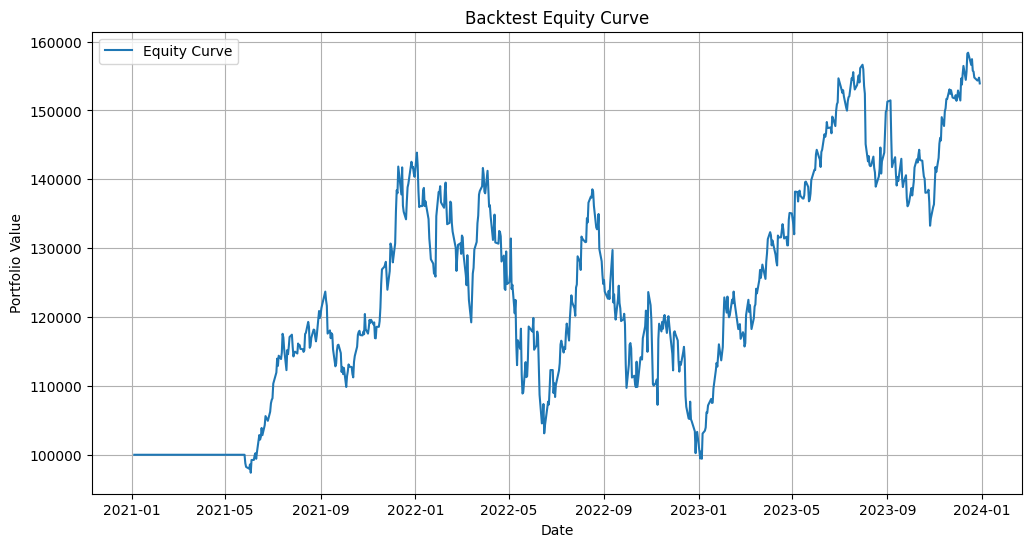

In [97]:
# Step 1: Download data
data = download_data('AAPL', '2021-01-01', '2024-01-01')

# Step 2: Apply a strategy and suppress output
with suppress_output():
    data = moving_average_strategy(data, short_window=40, long_window=100)

# Step 3: Backtest and suppress output
with suppress_output():
    initial_capital = 100000.0
    data, _ = backtest(data, initial_capital)

# Step 4: Generate report
generate_report(data, initial_capital)

[*********************100%***********************]  1 of 1 completed


Total Return:          43.09%
Annualized Return:     12.74%
Annualized Volatility: 27.39%
Sharpe Ratio:          0.47


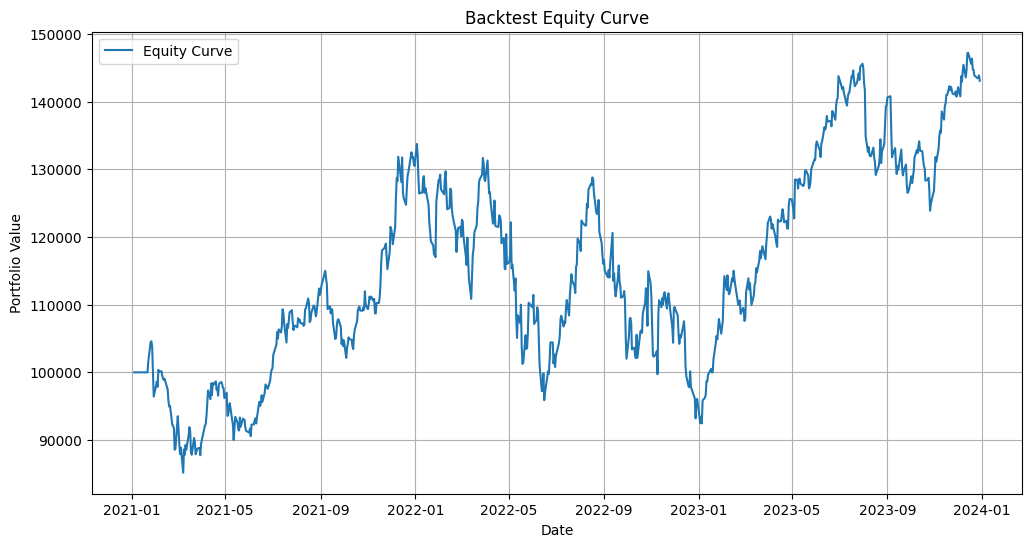

In [98]:
# Step 1: Download data
data = download_data('AAPL', '2021-01-01', '2024-01-01')

# Step 2: Apply a strategy and suppress output
with suppress_output():
    data = macd_strategy(data, short_window=12, long_window=26, signal_window=9)

# Step 3: Backtest and suppress output
with suppress_output():
    initial_capital = 100000.0
    data, _ = backtest(data, initial_capital)

# Step 4: Generate report
generate_report(data, initial_capital)

In [ ]:
# Create your own strategy here
# I've included MACD and RSI 

def new_strategy(data):
    # Calculate indicators
    data['macd'], data['signal_line'] = MACD(data, 12, 26, 9)
    data = compute_RSI(data, 14)

    # Initialize signals
    data['signal'] = 0

    # Buy when MACD > Signal Line and RSI < 30
    data['signal'] = np.where((data['macd'] > data['signal_line']) & (data['rsi'] < 40), 1, 0)

    # Sell when MACD < Signal Line and RSI > 70
    data['signal'] = np.where((data['macd'] < data['signal_line']) & (data['rsi'] > 60), -1, data['signal'])

    # Track position changes
    data['positions'] = data['signal'].diff()
    return data

[*********************100%***********************]  1 of 1 completed


Total Return:          53.34%
Annualized Return:     15.38%
Annualized Volatility: 13.53%
Sharpe Ratio:          1.14


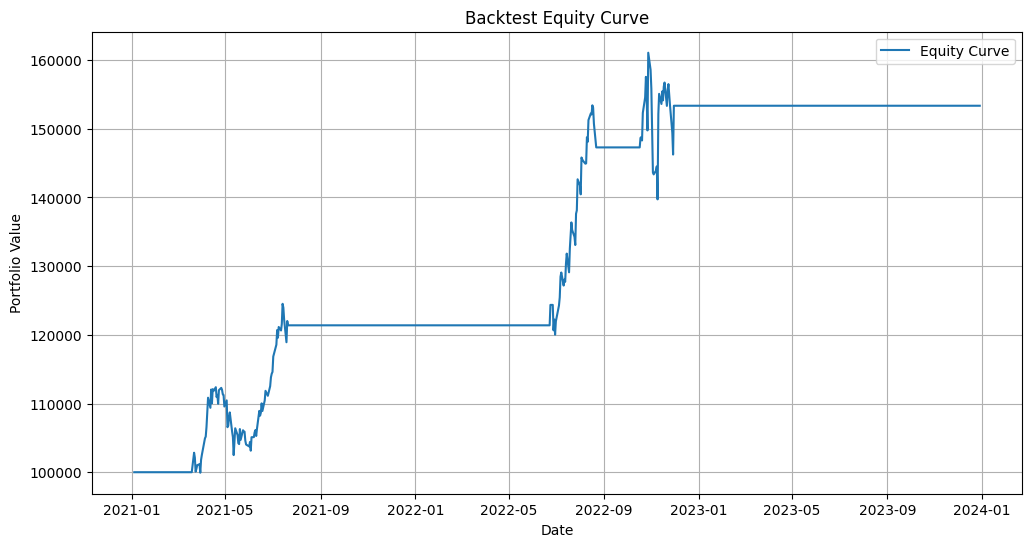

In [100]:
# Step 1: Download data
data = download_data('AAPL', '2021-01-01', '2024-01-01')

# Step 2: Apply a strategy and suppress output
with suppress_output():
    data = new_strategy(data)

# Step 3: Backtest and suppress output
with suppress_output():
    initial_capital = 100000.0
    data, _ = backtest(data, initial_capital)

# Step 4: Generate report
generate_report(data, initial_capital)
